# Gait classification

## Libraries and directory

In [228]:
#import packages, there might be some extras
import time
import os
import platform

import pandas as pd
import tensorflow as tf
import numpy as np
import numpy.random as npr
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import keras.utils
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import imageio
from tqdm import tqdm

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 'large'



In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
if platform.system() == "Darwin":
    root_directory = '/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition'
else:
    from google.colab import drive
    drive.mount('/content/drive')
    root_directory = '/content/drive/MyDrive/Human_Data/Progetto'

print('root directory is ' + root_directory)

root directory is /Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition


## Train/Test Split


In [4]:
# Create a dataframe containing all the files and the labels from the reference file
reference_df = pd.read_csv(root_directory+'/reference_document.csv',
                           header=None, names=['Name_file', 'Path_from_Root', 'Type_of_data', 'Type_of_gait', 'Label'])

reference_df = reference_df.iloc[1:]
reference_df['Label'] = reference_df['Label'].astype(int)

reference_df

,Name_file,Path_from_Root,Type_of_data,Type_of_gait,Label
1,Sbj9_antalgic_T2_S.csv,subject9/antalgic/trial2/,skeleton,antalgic,0
2,Sbj9_antalgic_T2_P.csv,subject9/antalgic/trial2/,pressure,antalgic,0
3,Sbj9_antalgic_T8_S.csv,subject9/antalgic/trial8/,skeleton,antalgic,0
4,Sbj9_antalgic_T8_P.csv,subject9/antalgic/trial8/,pressure,antalgic,0
5,Sbj9_antalgic_T14_P.csv,subject9/antalgic/trial14/,pressure,antalgic,0
...,...,...,...,...,...
2876,Sbj8_normal_T17_S.csv,subject8/normal/trial17/,skeleton,normal,2
2877,Sbj8_normal_T10_P.csv,subject8/normal/trial10/,pressure,normal,2
2878,Sbj8_normal_T10_S.csv,subject8/normal/trial10/,skeleton,normal,2
2879,Sbj8_normal_T6_P.csv,subject8/normal/trial6/,pressure,normal,2


In [5]:
def complete_path(row):
  complete_path = root_directory + '/dataset/' + row['Path_from_Root'] + row['Name_file']
  return complete_path

reference_df['Complete_path'] = reference_df.apply(complete_path, axis=1)
reference_df.set_index('Complete_path', inplace=True)
reference_df = reference_df.drop(columns=['Path_from_Root'])
reference_df

,Name_file,Type_of_data,Type_of_gait,Label
Complete_path,,,,
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject9/antalgic/trial2/Sbj9_antalgic_T2_S.csv,Sbj9_antalgic_T2_S.csv,skeleton,antalgic,0
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject9/antalgic/trial2/Sbj9_antalgic_T2_P.csv,Sbj9_antalgic_T2_P.csv,pressure,antalgic,0
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject9/antalgic/trial8/Sbj9_antalgic_T8_S.csv,Sbj9_antalgic_T8_S.csv,skeleton,antalgic,0
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject9/antalgic/trial8/Sbj9_antalgic_T8_P.csv,Sbj9_antalgic_T8_P.csv,pressure,antalgic,0
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject9/antalgic/trial14/Sbj9_antalgic_T14_P.csv,Sbj9_antalgic_T14_P.csv,pressure,antalgic,0
...,...,...,...,...
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject8/normal/trial17/Sbj8_normal_T17_S.csv,Sbj8_normal_T17_S.csv,skeleton,normal,2
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject8/normal/trial10/Sbj8_normal_T10_P.csv,Sbj8_normal_T10_P.csv,pressure,normal,2
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject8/normal/trial10/Sbj8_normal_T10_S.csv,Sbj8_normal_T10_S.csv,skeleton,normal,2


In [6]:
# recall
# LABELS = np.array(['antalgic', 'lurching', 'normal', 'steppage', 'stifflegged', 'trendelenburg'])

#split the dataframe into skeleton and pressure, drop the type column

reference_df_s = reference_df[reference_df['Type_of_data']=='skeleton']
reference_df_s = reference_df_s.drop(columns=['Type_of_data', 'Type_of_gait'])

reference_df_p = reference_df[reference_df['Type_of_data']=='pressure']
reference_df_p = reference_df_p.drop(columns=['Type_of_data', 'Type_of_gait'])

# We want to split the data using 11 subjects as training set and 1 subject as test set
# In this way we are sure that train and test are completely dinstinct

# train_test split
'''
train_s = reference_df_s[~reference_df_s['Name_file'].str.startswith('Sbj12')]
val_s = reference_df_s[reference_df_s['Name_file'].str.startswith('Sbj12')]

train_p = reference_df_p[~reference_df_p['Name_file'].str.startswith('Sbj12')]
val_p = reference_df_p[reference_df_p['Name_file'].str.startswith('Sbj12')]


#train_test split
train_s, val_s = train_test_split(reference_df_s, test_size=0.2, stratify=reference_df_s['Label'], random_state=123)
train_p, val_p = train_test_split(reference_df_p, test_size=0.2, stratify=reference_df_p['Label'], random_state=123)


train_s = train_s.drop(columns=['Name_file'])
val_s = val_s.drop(columns=['Name_file'])
train_p = train_p.drop(columns=['Name_file'])
val_p = val_p.drop(columns=['Name_file'])


#frequence counts
print("Training Skeleton")
print(train_s['Label'].value_counts())
print('\n',"Validation Skeleton")
print(val_s['Label'].value_counts())
print('\n',"Train Pressure")
print(train_p['Label'].value_counts())
print('\n',"Validation Pressure")
print(val_p['Label'].value_counts())

reference_df_s
'''

'\ntrain_s = reference_df_s[~reference_df_s[\'Name_file\'].str.startswith(\'Sbj12\')]\nval_s = reference_df_s[reference_df_s[\'Name_file\'].str.startswith(\'Sbj12\')]\n\ntrain_p = reference_df_p[~reference_df_p[\'Name_file\'].str.startswith(\'Sbj12\')]\nval_p = reference_df_p[reference_df_p[\'Name_file\'].str.startswith(\'Sbj12\')]\n\n\n#train_test split\ntrain_s, val_s = train_test_split(reference_df_s, test_size=0.2, stratify=reference_df_s[\'Label\'], random_state=123)\ntrain_p, val_p = train_test_split(reference_df_p, test_size=0.2, stratify=reference_df_p[\'Label\'], random_state=123)\n\n\ntrain_s = train_s.drop(columns=[\'Name_file\'])\nval_s = val_s.drop(columns=[\'Name_file\'])\ntrain_p = train_p.drop(columns=[\'Name_file\'])\nval_p = val_p.drop(columns=[\'Name_file\'])\n\n\n#frequence counts\nprint("Training Skeleton")\nprint(train_s[\'Label\'].value_counts())\nprint(\'\n\',"Validation Skeleton")\nprint(val_s[\'Label\'].value_counts())\nprint(\'\n\',"Train Pressure")\nprint(tr

In [19]:
leave_one_out = None   #index of the subject for validation [1,12], if None then random train/test split

if leave_one_out == None:
    print("Random train/test splitting ", '\n')
    train_s, val_s = train_test_split(reference_df_s, test_size=0.2, stratify=reference_df_s['Label'], random_state=123)
    train_p, val_p = train_test_split(reference_df_p, test_size=0.2, stratify=reference_df_p['Label'], random_state=123)

else:
    print("Leaving out subject ", leave_one_out, '\n')
    string = "Sbj" + str(leave_one_out)
    train_s = reference_df_s[~reference_df_s['Name_file'].str.startswith(string)]
    val_s = reference_df_s[reference_df_s['Name_file'].str.startswith(string)]

    train_p = reference_df_p[~reference_df_p['Name_file'].str.startswith(string)]
    val_p = reference_df_p[reference_df_p['Name_file'].str.startswith(string)]
    
    
train_s = train_s.drop(columns=['Name_file'])
val_s = val_s.drop(columns=['Name_file'])
train_p = train_p.drop(columns=['Name_file'])
val_p = val_p.drop(columns=['Name_file'])


#frequence counts
print("Training Skeleton")
print(train_s['Label'].value_counts())
print('\n',"Validation Skeleton")
print(val_s['Label'].value_counts())
print('\n',"Train Pressure")
print(train_p['Label'].value_counts())
print('\n',"Validation Pressure")
print(val_p['Label'].value_counts())
        
    

Random train/test splitting  

Training Skeleton
5    192
3    192
4    192
0    192
1    192
2    192
Name: Label, dtype: int64

 Validation Skeleton
3    48
2    48
1    48
4    48
5    48
0    48
Name: Label, dtype: int64

 Train Pressure
5    192
3    192
4    192
0    192
1    192
2    192
Name: Label, dtype: int64

 Validation Pressure
3    48
2    48
1    48
4    48
5    48
0    48
Name: Label, dtype: int64


## Skeleton: load and preprocessing

### Defenition of the load function

In [ ]:
def load_data_sk(complete_path, load=True):

  if load:
    complete_path = complete_path.decode()
    print(complete_path)

  df_skelly = pd.read_csv(complete_path, header=None)
  df_skelly = df_skelly.drop([df_skelly.columns[0],df_skelly.columns[-1]], axis=1)

  #convert to np array and reshape
  data = df_skelly.to_numpy().reshape((-1,32,3))

  return data.squeeze()


# Example
sk_data = load_data_sk(train_s.index[1], load=False)

#plot example, select only one frame
plotdata = sk_data[150]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot')
ax.view_init(elev=10, azim=80)
plt.show()

### Definition of the normalization function

In [ ]:
def normalize_data_sk(data):
    # Amplitude estimate for each axes
    norm_factor_x = np.percentile(data[:, :, 0], 95) - np.percentile(data[:, :, 0], 5)
    norm_factor_y = np.percentile(data[:, :, 1], 95) - np.percentile(data[:, :, 1], 5)
    norm_factor_z = np.percentile(data[:, :, 2], 95) - np.percentile(data[:, :, 2], 5)

    data[:, :, 0] = data[:, :, 0] / norm_factor_x
    data[:, :, 1] = data[:, :, 1] / norm_factor_y
    data[:, :, 2] = data[:, :, 2] / norm_factor_z

    return data


# Example
sk_data = load_data_sk(train_s.index[1], load=False)
sk_data_norm = normalize_data_sk(sk_data)


#plot example, select only one frame
plotdata = sk_data[150]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot')
ax.view_init(elev=10, azim=80)
plt.show()

Perche' all'inizio veloce e poi lenta?

In [ ]:
# # check duration of walking samples
# hist = []

# c = 0

# for i in reference_df_s.index:
#     data = load_data_sk(i, reference_df_s)
#     hist.append(data.shape[0])

#     if c % 100 == 0:
#       print('Step:', c)
#     c += 1

# # Create a histogram
# plt.hist(hist, bins=150, edgecolor='black')

# # Add a vertical line for the median
# plt.axvline(np.median(hist), color='red', linestyle='dashed', linewidth=1)
# plt.axvline(np.mean(hist), color='yellow', linestyle='dashed', linewidth=1)

# # Add labels and title
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Histogram')

# # Show the plot
# plt.show()
# print("Median of data (red)",np.median(hist))
# print("Mean of data (yellow)",np.mean(hist))
# print("Standard dev of data", np.std(hist))

### Definition of the crop function

In [ ]:
def random_crop(data, target_size=50, noise_time=20, center_crop=False):

  # remove initial and final frames that we consider as noise
  start = noise_time
  end = data.shape[0] - noise_time

  data = data[start:end, :]

  N = data.shape[0]

  # Random Crop (always centered if center_crop=True)
  if center_crop:
      from_ = int((N / 2) - (target_size / 2))
      # print('Start of the crop: ', from_)
  else:
      from_ = np.random.randint(0, np.floor(N - target_size))
      # print('Start of the crop: ', from_)

  return data[from_:from_ + target_size]


# Example
sk_data = load_data_sk(train_s.index[1], load=False)

sk_data_crop = random_crop(sk_data)
print('Original shape ', sk_data.shape, 'Cropped/Padded shape ', sk_data_crop.shape)

### Unique load_preprocessing and one_hot_encoding function

In [ ]:
def load_prep_sk(complete_path):
    data = load_data_sk(complete_path, load=True)
    data = normalize_data_sk(data)

    # riportati i dati in un vettore pronti per il RNN
    data = data.reshape(data.shape[0], -1)

    return data.astype(np.float32)

In [ ]:
'''
def one_hot(indice):

  matrix = np.zeros((len(indice), 6))
  matrix[np.arange(len(indice)), indice] = 1

  return matrix
'''

## Skeleton dataset

### Defenition of the function to create the dataset

In [ ]:
def create_dataset_sk(table, cache_file, shuffle, batch_size, target_size=50, noise_time=20, center_crop=False):

  # shape
  input_size = (target_size, 96)

  # Convert dataframe to lists
  file_names = list(table.index)
  labels = table['Label']

  # Create a Dataset object
  dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))
  # dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))

  # Map the load_and_preprocess_data function
  py_func = lambda path, label: (tf.numpy_function(load_prep_sk, [path], tf.float32), label)
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Cache dataset
  if cache_file:
      dataset = dataset.cache(cache_file)

  # # Shuffle
  # if shuffle:
  #     dataset = dataset.shuffle(len(file_names))

  # Repeat the dataset indefinitely
  dataset = dataset.repeat()

  # Map the crop function
  py_func = lambda data, label: (tf.ensure_shape(tf.numpy_function(random_crop, [data, target_size, noise_time, center_crop], tf.float32),
                                              input_size), label)
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # # # Correct input shape for the network
  # dataset = dataset.map(lambda data, label: (tf.expand_dims(data, 2), label))

  # Batch
  dataset = dataset.batch(batch_size=batch_size)

  # Prefetch
  dataset = dataset.prefetch(buffer_size=1)

  return dataset


### Dataset inizialization

In [ ]:
batch_s = 20

dataset_train_s = create_dataset_sk(table = train_s,
                                    cache_file = 'train_s_cache_int_label',
                                    shuffle = True,
                                    batch_size = batch_s,
                                    target_size = 50,
                                    noise_time = 20,
                                    center_crop = False)

dataset_val_s = create_dataset_sk(table = val_s,
                                    cache_file = 'val_s_cache',
                                    shuffle = False,
                                    batch_size = batch_s,
                                    target_size = 50,
                                    noise_time = 20,
                                    center_crop = False)

train_steps_s = int(np.ceil(len(train_s)/batch_s))
val_steps_s = int(np.ceil(len(val_s)/batch_s))

In [ ]:
# first_element_dataset_k = dataset_train_s.take(1)
# first_element_dataset_k

In [ ]:
# for d, l in first_element_dataset_k:
#   print(d.numpy().shape, l)

## Pressure: load and preprocessing

### Defenition of the load function

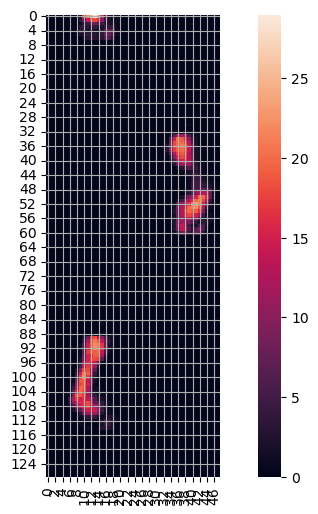

In [20]:
def load_data_ps(complete_path, load=True):

  if load:
    complete_path = complete_path.decode()

  pressure_data = pd.read_csv(complete_path, header=None).to_numpy()

  return pressure_data.squeeze()


# Example
ps_data = load_data_ps(train_p.index[0], load=False)

sns.heatmap(ps_data, square= True)
plt.show()

### Definition of the normalization function

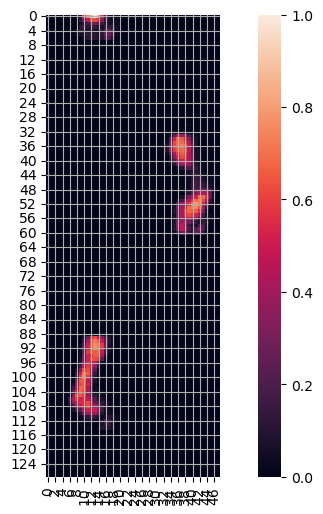

In [21]:
def normalize_data_ps(data):
    max_data = np.max(data)
    data = data / max_data
    return data

# Example
ps_data = load_data_ps(train_p.index[0], load=False)
ps_data_norm = normalize_data_ps(ps_data)

sns.heatmap(ps_data_norm, square= True)
plt.show()

### Definition of the centering function

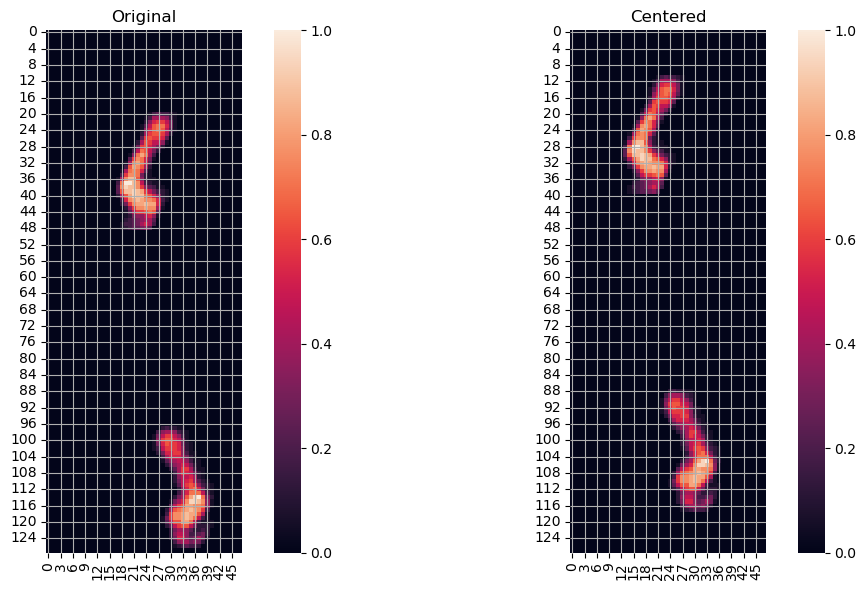

In [22]:
def barycenter(data):
  # Compute the weighted average (barycenter) along each dimension
  y_barycenter = np.average(np.arange(data.shape[0]), weights=np.sum(data, axis=1))
  x_barycenter = np.average(np.arange(data.shape[1]), weights=np.sum(data, axis=0))

  # print("Barycenter coordinates (x,y) = ",x_barycenter,y_barycenter)
  # print("Center image (x,y) = ", data.shape[1]/2, data.shape[0]/2)

  # Compute the distances between each point and the barycenter
  shift_x = -(x_barycenter - data.shape[1]/2)
  shift_y = -(y_barycenter - data.shape[0]/2)

  # Shift the foot pressure matrix to be centered on the barycenter
  shifted_matrix = np.roll(data, int(shift_x), axis=1)
  shifted_matrix = np.roll(shifted_matrix, int(shift_y), axis=0)

  # y_barycenter_after = np.average(np.arange(shifted_matrix.shape[0]), weights=np.sum(shifted_matrix, axis=1))
  # x_barycenter_after = np.average(np.arange(shifted_matrix.shape[1]), weights=np.sum(shifted_matrix, axis=0))
  # print("Barycenter coordinates (x,y) afetr= ", x_barycenter_after, y_barycenter_after, '\n')

  return shifted_matrix

# Example
for i in [253]:
  ps_data = load_data_ps(train_p.index[i], load=False)
  ps_data_norm = normalize_data_ps(ps_data)
  cen_ps_data_norm = barycenter(ps_data_norm)

  fig, axes = plt.subplots(1, 2, figsize=(12, 6))

  # Plot the first heatmap
  sns.heatmap(ps_data_norm, square=True, ax=axes[0])
  axes[0].set_title('Original')

  # Plot the second heatmap
  sns.heatmap(cen_ps_data_norm, square=True,ax=axes[1])
  axes[1].set_title('Centered')

  # Adjust layout
  plt.tight_layout()

  # Show the plot
  plt.show()

### Augment data
Will perform ad hoc image data augmentation, random horizontal flip and random vertical roll of the sample

In [185]:
a=npr.random()
a

0.39699106722159294

In [191]:
npr.random()

0.4957459199047224

In [202]:
def augment_data(data, flip_rate, roll_rate, max_roll):
    a = npr.random()
    b = npr.random()
    
    if a < flip_rate:
        print("Flip data")
        data = np.flip(data, axis=1)
    
    if b < roll_rate:
        shift = int((npr.random()*2-1)*max_roll)
        print("Roll data by ", shift)
        data = np.roll(data, int(shift), axis=0)
    
    return data

Flip data
Roll data by  3


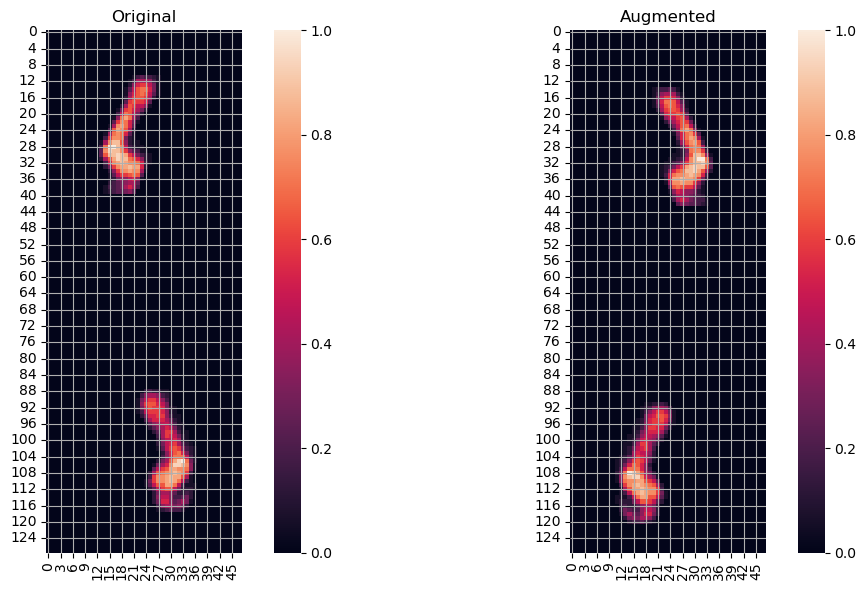

In [212]:
test = augment_data(cen_ps_data_norm, 1, 1, 13)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first heatmap
sns.heatmap(cen_ps_data_norm, square=True, ax=axes[0])
axes[0].set_title('Original')

# Plot the second heatmap
sns.heatmap(test, square=True,ax=axes[1])
axes[1].set_title('Augmented')

# Adjust layout
plt.tight_layout()
# Show the plot
plt.show()

### Unique load_preprocessing and one_hot_encoding function

In [23]:
def load_prep_ps(complete_path):
    data = load_data_ps(complete_path, load=True)
    data = normalize_data_ps(data)
    data = barycenter(data)

    return data.astype(np.float32)

In [ ]:
'''def one_hot(indice):

  matrix = np.zeros((len(indice), 6))
  matrix[np.arange(len(indice)), indice] = 1

  return matrix'''

## Pressure dataset

### Definition of the function to create the dataset

In [219]:
def create_dataset_ps(table, cache_file, shuffle, batch_size):

  # Convert dataframe to lists
  file_names = list(table.index)
  labels = table['Label']

  # Create a Dataset object
  dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))

    # Shuffle
  if shuffle:
      dataset = dataset.shuffle(len(table))

  # Map the load_and_preprocess_data function
  py_func = lambda path, label: (tf.numpy_function(load_prep_ps, [path], tf.float32), label)
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())
    
  #Augment data 
  #if augment:
      #dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), 
          #      num_parallel_calls=os.cpu_count())

  # Cache dataset
  if cache_file:
      dataset = dataset.cache(cache_file)

  # Repeat the dataset indefinitely
  dataset = dataset.repeat()

  # Correct input shape for the network
  dataset = dataset.map(lambda data, label: (tf.expand_dims(data, 2), label))

  # Batch
  dataset = dataset.batch(batch_size=batch_size)

  # Prefetch
  dataset = dataset.prefetch(buffer_size=1)

  return dataset


### Dataset inizialization

In [220]:
batch_p = 30

dataset_train_p = create_dataset_ps(table = train_p,
                                    cache_file = 'train_p_cache',
                                    shuffle = True,
                                    batch_size = batch_p)

dataset_val_p = create_dataset_ps(table = val_p,
                                    cache_file = 'val_p_cache',
                                    shuffle = False,
                                    batch_size = batch_p)

train_steps_p = int(np.ceil(len(train_p)/batch_p))
val_steps_p = int(np.ceil(len(val_p)/batch_p))

In [221]:
first_element_dataset_p = dataset_train_p.take(1)
first_element_dataset_p

<TakeDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [222]:
for d, l in first_element_dataset_p:
  print(d.numpy().shape, l.numpy().shape)

(24, 128, 48, 1) (24,)


## RNN

In [56]:
def MyModel_RNN(time_length, n_features):

  X_input = tf.keras.Input((time_length, 96))

  # Linear_part
  x = tf.keras.layers.Dense(units=n_features, activation='relu', input_shape=(time_length, n_features))(X_input)

  # RNN part
  # h(t) = tanh(W_hx * x(t) + W_hh * h(t-1) + bias)
  x = tf.keras.layers.GRU(125, return_sequences=True, activation='tanh', name='I_GRU')(x)

  x = tf.keras.layers.GRU(125, return_sequences=True, activation='tanh', name='II_GRU')(x)
  x = tf.keras.layers.GRU(125, return_sequences=True, activation='tanh', name='III_GRU')(x)
  x = tf.keras.layers.GRU(125, return_sequences=False, activation='tanh', name='IV_GRU')(x)

  # Flatten_output
  x = tf.keras.layers.Flatten()(x)                                                                       # serve davvero il flatten?

  # Linear part
  x = tf.keras.layers.Dense(64, activation='relu', name='I_layer')(x)
  x = tf.keras.layers.Dense(32, activation='relu', name='II_layer')(x)
  x = tf.keras.layers.Dense(16, activation='relu', name='III_layer')(x)

  # Last layer
  RNN_outputs = tf.keras.layers.Dense(6, activation='softmax', name='Output_layer')(x)

  # Create model
  model = tf.keras.Model(inputs = X_input, outputs = RNN_outputs, name='RNN_model')

  return model


RNN_classifier_model = MyModel_RNN(50, 96)
RNN_classifier_model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

print(RNN_classifier_model.summary(), '\n')

Model: "RNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 50, 96)]          0         
                                                                 
 dense (Dense)               (None, 50, 96)            9312      
                                                                 
 I_GRU (GRU)                 (None, 50, 125)           83625     
                                                                 
 II_GRU (GRU)                (None, 50, 125)           94500     
                                                                 
 III_GRU (GRU)               (None, 50, 125)           94500     
                                                                 
 IV_GRU (GRU)                (None, 125)               94500     
                                                                 
 flatten_9 (Flatten)         (None, 125)               0 

In [167]:
# Train the model
num_epochs = 30

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       patience=5)

# Fit the model
history = RNN_classifier_model.fit(dataset_train_s,
                                   epochs=num_epochs,
                                   steps_per_epoch=train_steps_s,
                                   validation_data=dataset_val_s,
                                   validation_steps=val_steps,
                                   callbacks=[early_stop_callback])


RNN_classifier_model.save('RNN/RNN_model')

NameError: name 'dataset_train_s' is not defined

## CNN

In [232]:
def MyModel_CNN(side_1, side_2, side_3, weight_L2):

  CNN_inputs = tf.keras.Input(shape=(side_1, side_2, side_3))

  x = tf.keras.layers.Conv2D(filters = 32,
                            kernel_size = 3,
                            strides = 1,
                            padding = 'same',
                            activation = 'elu',
                            name='I_Conv2D', kernel_regularizer=regularizers.l2(weight_L2))(CNN_inputs)
  x = tf.keras.layers.MaxPool2D(pool_size = 2)(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(64, 3, 1, padding='same', activation = 'elu', name='II_Conv2D',kernel_regularizer=regularizers.l2(weight_L2))(x)
  x = tf.keras.layers.MaxPool2D(2)(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(128, 3, 1, padding='same', activation = 'elu', name='III_Conv2D',kernel_regularizer=regularizers.l2(weight_L2))(x)
  x = tf.keras.layers.MaxPool2D(2)(x)
  x = tf.keras.layers.BatchNormalization()(x) 
  x = tf.keras.layers.Dropout(0.1)(x)

  x = tf.keras.layers.Flatten()(x)

  x = tf.keras.layers.Dense(128, activation='elu', name='I_layer',kernel_regularizer=regularizers.l2(weight_L2))(x)  
  x = tf.keras.layers.Dense(64, activation='elu', name='II_layer',kernel_regularizer=regularizers.l2(weight_L2))(x)
  x = tf.keras.layers.Dense(32, activation='elu', name='III_layer',kernel_regularizer=regularizers.l2(weight_L2))(x)
  x = tf.keras.layers.Dense(16, activation='elu', name='IV_layer',kernel_regularizer=regularizers.l2(weight_L2))(x)
  x = tf.keras.layers.Dropout(0.1)(x)
                                                                                        
  CNN_outputs = tf.keras.layers.Dense(6, activation='softmax', name='Output_layer')(x)

  # Create model
  model = tf.keras.Model(inputs=CNN_inputs, outputs=CNN_outputs)

  return model


CNN_classifier_model = MyModel_CNN(128, 48, 1, 0.01)
CNN_classifier_model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

print(CNN_classifier_model.summary(), '\n')

Model: "model_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_93 (InputLayer)       [(None, 128, 48, 1)]      0         
                                                                 
 I_Conv2D (Conv2D)           (None, 128, 48, 32)       320       
                                                                 
 max_pooling2d_165 (MaxPooli  (None, 64, 24, 32)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_165 (Ba  (None, 64, 24, 32)       128       
 tchNormalization)                                               
                                                                 
 II_Conv2D (Conv2D)          (None, 64, 24, 64)        18496     
                                                                 
 max_pooling2d_166 (MaxPooli  (None, 32, 12, 64)       0  

In [233]:
# Train the model
num_epochs = 20

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                       patience=10)

# Fit the model
history = CNN_classifier_model.fit(dataset_train_p,
                                   epochs=num_epochs,
                                   steps_per_epoch=train_steps_p,
                                   validation_data=dataset_val_p,
                                   validation_steps=val_steps_p,
                                   callbacks=[early_stop_callback])


CNN_classifier_model.save('CNN/CNN_model')

Epoch 1/20
48/48 [==============================] - 8s 145ms/step - loss: 8.1437 - accuracy: 0.2196 - val_loss: 7.1451 - val_accuracy: 0.2083
Epoch 2/20
48/48 [==============================] - 8s 157ms/step - loss: 7.1551 - accuracy: 0.2561 - val_loss: 6.8004 - val_accuracy: 0.2083
Epoch 3/20
48/48 [==============================] - 7s 142ms/step - loss: 6.2813 - accuracy: 0.3524 - val_loss: 6.0124 - val_accuracy: 0.2083
Epoch 4/20
48/48 [==============================] - 7s 139ms/step - loss: 5.6675 - accuracy: 0.3507 - val_loss: 5.5683 - val_accuracy: 0.2083
Epoch 5/20
48/48 [==============================] - 7s 156ms/step - loss: 4.9348 - accuracy: 0.4314 - val_loss: 5.0094 - val_accuracy: 0.1458
Epoch 6/20
48/48 [==============================] - 9s 186ms/step - loss: 4.3272 - accuracy: 0.4870 - val_loss: 4.4760 - val_accuracy: 0.4167
Epoch 7/20
48/48 [==============================] - 9s 188ms/step - loss: 3.8078 - accuracy: 0.5538 - val_loss: 4.3757 - val_accuracy: 0.2812
Epoch 

INFO:tensorflow:Assets written to: CNN/CNN_model/assets


INFO:tensorflow:Assets written to: CNN/CNN_model/assets


Text(0, 0.5, 'Accuracy')

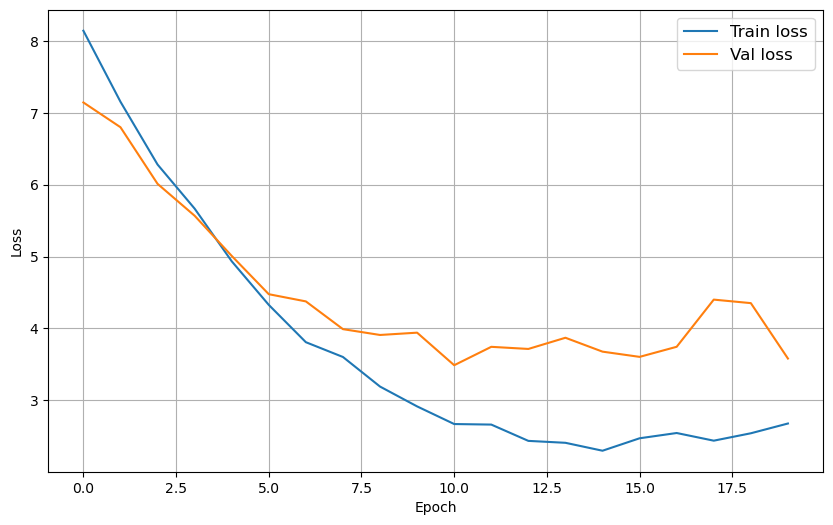

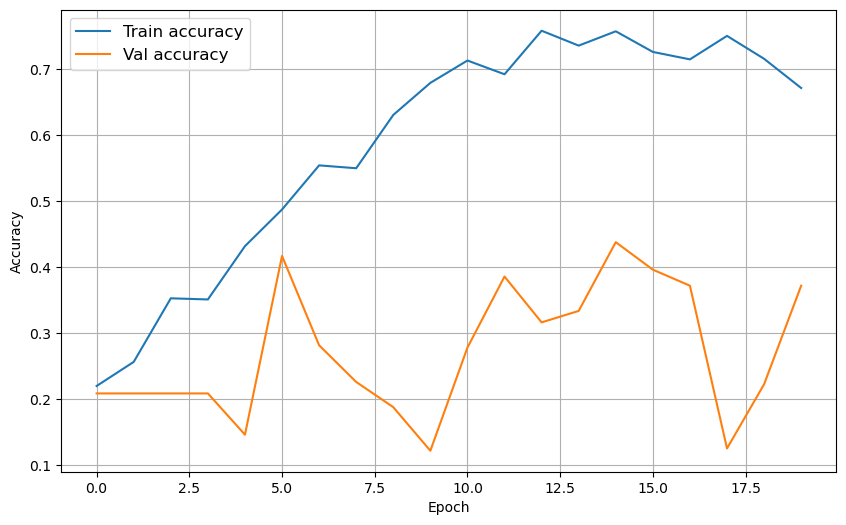

In [235]:
# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [165]:
pred = CNN_classifier_model.predict(dataset_val_p, steps = 2)

1/1 [==============================] - 0s 459ms/step


In [166]:
pred.shape

(30, 6)

In [ ]:
confusion_matrix(pred,)

### Encoder and decoder

In [139]:
def CNN_enc(input_shape):

  CNN_inputs = tf.keras.Input(shape=(input_shape))

  x = tf.keras.layers.Conv2D(filters = 32,
                            kernel_size = 3,
                            strides = (1,1),
                            padding = 'same',
                            activation = 'relu',
                            name='I_Conv2D')(CNN_inputs)
  x = tf.keras.layers.MaxPool2D(pool_size = 2)(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(64, 3, 1, padding='same', activation = 'relu', name='II_Conv2D')(x)
  x = tf.keras.layers.MaxPool2D(2)(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(128, 3, 1, padding='same', activation = 'relu', name='III_Conv2D')(x)
  x = tf.keras.layers.MaxPool2D(2)(x)
  x = tf.keras.layers.BatchNormalization()(x) 
  x = tf.keras.layers.Dropout(0.1)(x)

  x = tf.keras.layers.Flatten()(x)

  x = tf.keras.layers.Dense(64, activation='relu', name='I_layer')(x)
  x = tf.keras.layers.Dense(32, activation='relu', name='II_layer')(x)
  output = tf.keras.layers.Dense(16, activation='relu', name='out_layer')(x)

  # Create model
  model = tf.keras.Model(inputs=CNN_inputs, outputs=output)

  return model, CNN_inputs


CNN_encoder,_ = CNN_enc((128, 48, 1))

print(CNN_encoder.summary(), '\n')

Model: "model_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_80 (InputLayer)       [(None, 128, 48, 1)]      0         
                                                                 
 I_Conv2D (Conv2D)           (None, 128, 48, 32)       320       
                                                                 
 max_pooling2d_135 (MaxPooli  (None, 64, 24, 32)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_135 (Ba  (None, 64, 24, 32)       128       
 tchNormalization)                                               
                                                                 
 II_Conv2D (Conv2D)          (None, 64, 24, 64)        18496     
                                                                 
 max_pooling2d_136 (MaxPooli  (None, 32, 12, 64)       0  

In [140]:
def CNN_dec(input_shape):
    dec_inputs = tf.keras.Input(shape=(input_shape,))
    
    x = tf.keras.layers.Dense(32, activation='relu', name='I_layer')(dec_inputs)
    x = tf.keras.layers.Dense(64, activation='relu', name='II_layer')(x)
    x = tf.keras.layers.Dense(128, activation='relu', name='III_layer')(x)
    x = tf.keras.layers.Dense(16*6*128, activation='relu', name='IV_layer')(x)
    
    x = tf.keras.layers.Reshape((16,6,128))(x)
    
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, activation='elu', padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation='elu', padding='same')(x)
    #x = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation='elu', padding='same')(x)
    output = tf.keras.layers.Conv2DTranspose(1, (3, 3), strides=2, activation=None, padding='same')(x)
    
    # Create model
    model = tf.keras.Model(inputs=dec_inputs, outputs=output)
    return model


CNN_decoder = CNN_dec(16)
#CNN_decoder.compile(
#    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#    optimizer = keras.optimizers.Adam(learning_rate=0.001),
#    metrics=['accuracy'])

print(CNN_decoder.summary(), '\n')
    
    


Model: "model_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_81 (InputLayer)       [(None, 16)]              0         
                                                                 
 I_layer (Dense)             (None, 32)                544       
                                                                 
 II_layer (Dense)            (None, 64)                2112      
                                                                 
 III_layer (Dense)           (None, 128)               8320      
                                                                 
 IV_layer (Dense)            (None, 12288)             1585152   
                                                                 
 reshape_13 (Reshape)        (None, 16, 6, 128)        0         
                                                                 
 conv2d_transpose_40 (Conv2D  (None, 32, 12, 64)       737

In [124]:
IMG_SHAPE = (128, 48, 1)

# Define your encoder model
encoder_input = tf.keras.Input(shape=IMG_SHAPE)
encoder_output = CNN_enc(encoder_input)
encoder_model = tf.keras.Model(encoder_input, encoder_output)

# Define your decoder model
decoder_input = tf.keras.Input(shape=encoder_output.shape[1:])
decoder_output = CNN_dec(decoder_input)
decoder_model = tf.keras.Model(decoder_input, decoder_output)

TypeError: Cannot iterate over a Tensor with unknown first dimension.

In [142]:
# FUNCTION: define a convolutional autoencoder as described above

def build_deep_autoencoder(img_shape, code_size):
    """
    Arguments:
    img_shape_x -- size of the input layer
    code_size -- the size of the hidden representation of the input (code)

    Returns:
    encoder -- keras model for the encoder network
    decoder -- keras model for the decoder network
    """

    # encoder
    ### START CODE HERE ###
    encoder = tf.keras.Sequential()
    encoder.add(tf.keras.Input(img_shape))

    encoder.add(layers.Conv2D(32, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(layers.Conv2D(64, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(layers.Conv2D(256, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(layers.Flatten())
    encoder.add(layers.Dense(code_size))
    ### END CODE HERE ###

    # decoder
    ### START CODE HERE ###
    decoder = tf.keras.Sequential()
    decoder.add(tf.keras.Input((code_size,)))

    decoder.add(layers.Dense(6 * 6 * 256, activation='elu'))
    decoder.add(layers.Reshape((6, 6, 256)))
    decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, activation='elu', padding='valid'))
    decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(layers.Conv2DTranspose(3, (3, 3), strides=2, activation=None, padding='same'))
    ### END CODE HERE ###

    return encoder, decoder

## Burn everything

In [ ]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()